## Prepping Data
- Query in IPUMS 
- Download R script, data extract
- Modify R script to add `write.csv(data, file = "census.csv")`

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import time

In [68]:
data = pd.read_csv('./data/census.csv').drop(columns='Unnamed: 0')

In [69]:
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,SEX,AGE,MARST,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,FTOTINC
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,1,73,3,2,200,2,25,3,30,10000.0
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,2,31,6,1,100,10,101,1,10,38500.0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,1,41,1,1,100,6,64,1,10,90700.0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,2,48,1,1,100,6,63,3,30,90700.0
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,1,16,6,1,100,4,40,3,30,90700.0


For neighborhood type category, need to calculate tract-weighted average density for each PUMA

In [70]:
puma_total_counts_df = data['PUMA'].value_counts()
data['PUMA_TOTAL_POP'] = data['PUMA'].map(puma_total_counts_df)

Perform one-hot encoding on categorical data (sex, race/ethnicity, neighborhood type, marital status, education, employment status), extract relevant columns for clustering

In [71]:
categorical_vars = ['SEX', 'RACE', 'MARST', 'EDUC', 'EMPSTAT']
data = pd.get_dummies(data, columns=categorical_vars)

In [72]:
data.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'PUMA', 'GQ', 'PERNUM',
       'PERWT', 'AGE', 'RACED', 'EDUCD', 'EMPSTATD', 'FTOTINC',
       'PUMA_TOTAL_POP', 'SEX_1', 'SEX_2', 'RACE_1', 'RACE_2', 'RACE_3',
       'RACE_4', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8', 'RACE_9', 'MARST_1',
       'MARST_2', 'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6', 'EDUC_0',
       'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5', 'EDUC_6', 'EDUC_7',
       'EDUC_8', 'EDUC_10', 'EDUC_11', 'EMPSTAT_0', 'EMPSTAT_1', 'EMPSTAT_2',
       'EMPSTAT_3'],
      dtype='object')

In [73]:
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,AGE,...,EDUC_5,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,73,...,0,0,0,0,0,0,0,0,0,1
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,31,...,0,0,0,0,1,0,0,1,0,0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,41,...,0,1,0,0,0,0,0,1,0,0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,48,...,0,1,0,0,0,0,0,0,0,1
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,16,...,0,0,0,0,0,0,0,0,0,1


Extract only relevant columns and normalize

In [79]:
relevant_data = data.filter(regex='AGE|RACE$|SEX|PUMA_TOTAL_POP|MARST|EDUC_|FTOTINC|EMPSTAT_')

In [80]:
relevant_data.columns

Index(['AGE', 'FTOTINC', 'PUMA_TOTAL_POP', 'SEX_1', 'SEX_2', 'MARST_1',
       'MARST_2', 'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6', 'EDUC_0',
       'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5', 'EDUC_6', 'EDUC_7',
       'EDUC_8', 'EDUC_10', 'EDUC_11', 'EMPSTAT_0', 'EMPSTAT_1', 'EMPSTAT_2',
       'EMPSTAT_3'],
      dtype='object')

In [81]:
scaler = StandardScaler()
scaler.fit(relevant_data)
scaled_data = scaler.transform(relevant_data)

Use DSCAN to estimate # of clusters

In [ ]:
runs = 2
num_clusters_list = []
sample_ratio = .1
dbscan_min_samples = 500

time_flag = True # use this to measure the time to run DBSCAN for each sample run, for me it was ~4500s per iteration using 

if time_flag:
    t0 = time.time()

for _ in range(runs):
    num_samples = int(sample_ratio * scaled_data.shape[0])
    samples = scaled_data[np.random.choice(scaled_data.shape[0], num_samples, replace=True)]
    db = DBSCAN(min_samples=dbscan_min_samples).fit(samples)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters_list.append(n_clusters_)
    
    if time_flag:
        t1 = time.time()
        delta = t1 - t0
        t0 = t1
        print(delta)
        
print('num_clusters_list:', num_clusters_list)
optimal_n = int(np.rint(np.mean(num_clusters_list)))

In [82]:
optimal_n = 39

In [83]:
kmeans = KMeans(n_clusters=optimal_n).fit(scaled_data)
# kmeans.cluster_centers_

In [84]:
labels, counts = np.unique(kmeans.labels_, return_counts=True)

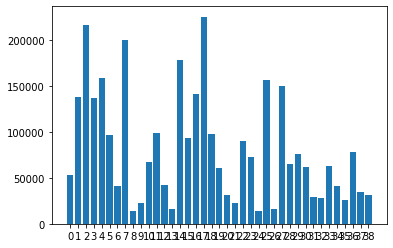

In [16]:
plt.bar(range(len(counts)), counts)
plt.xticks(range(len(labels)), labels)
plt.show()

In [85]:
num_clusters = 8
largest_clusters_indexes = np.argsort(counts)
largest_cluster_centriods = kmeans.cluster_centers_[largest_clusters_indexes]
cluster_centriods_rescaled = []
for index in range(num_clusters):
    centriod_rescaled = dict(zip(relevant_data.columns, scaler.inverse_transform(largest_cluster_centriods[index])))
    print(centriod_rescaled, '\n')
    cluster_centriods_rescaled.append(centriod_rescaled)

{'AGE': 57.27920373341112, 'FTOTINC': 9999999.00000154, 'PUMA_TOTAL_POP': 17583.115283651758, 'SEX_1': 0.6849205191775021, 'SEX_2': 0.315079480822498, 'MARST_1': 7.993605777301127e-14, 'MARST_2': 0.9999999999998195, 'MARST_3': 4.9057979900624105e-15, 'MARST_4': -9.534040223968532e-15, 'MARST_5': 2.8727020762175925e-15, 'MARST_6': 1.2445600106048005e-13, 'EDUC_0': 0.013052355257391145, 'EDUC_1': 0.013125273443193738, 'EDUC_2': 0.07109523115065097, 'EDUC_3': 0.032011083564242634, 'EDUC_4': 0.045719702493798815, 'EDUC_5': 0.05395945748869399, 'EDUC_6': 0.4356132419425663, 'EDUC_7': 0.14889893539448645, 'EDUC_8': 0.044844684264254, 'EDUC_10': 0.09406445967624086, 'EDUC_11': 0.047615575324487236, 'EMPSTAT_0': 0.00021875455738815108, 'EMPSTAT_1': 0.12337757036605057, 'EMPSTAT_2': 0.006781391278989916, 'EMPSTAT_3': 0.8696222837974774} 

{'AGE': 54.02098608409392, 'FTOTINC': 365891.2911865946, 'PUMA_TOTAL_POP': 16218.795750411504, 'SEX_1': 0.3572123297920551, 'SEX_2': 0.6427876702079449, 'MARS

In [93]:
soup = BeautifulSoup(open('./data/usa_00001.xml'), 'xml')

def cluster_decoder(cluster): # cluster needs to be rescaled to original scale
    result = ''
    decoded_dict = {}
    pattern = r'(?P<cat>\w*)_(?P<encoding>\d+)'
    
    for cat, val in cluster.items():
        # match category to categorical variable
        regex_result = re.match(pattern, cat)
        if regex_result:
            # find categorical variable in the soup
            category = regex_result.group('cat')
            cur_soup = soup.dataDscr.find('var', {'ID': category})
            # translate encoded category to english
            cat_valu_int = int(np.rint(int(regex_result.group('encoding'))))
            rounded_val = int(np.rint(val))
            if rounded_val > 0:
                # if 
                for soup_catgry in cur_soup.find_all('catgry'):
                    if int(soup_catgry.catValu.string) == cat_valu_int:
                        # decode encoding
                        decoded_dict[category] = soup_catgry.labl.string
        else:
            decoded_dict[cat] = val
    return decoded_dict
    
for cluster in cluster_centriods_rescaled:
    print(cluster_decoder(cluster))

{'AGE': 57.27920373341112, 'FTOTINC': 9999999.00000154, 'PUMA_TOTAL_POP': 17583.115283651758, 'SEX': 'Male', 'MARST': 'Married, spouse absent', 'EMPSTAT': 'Not in labor force'}
{'AGE': 54.02098608409392, 'FTOTINC': 365891.2911865946, 'PUMA_TOTAL_POP': 16218.795750411504, 'SEX': 'Female', 'MARST': 'Divorced', 'EDUC': '2 years of college', 'EMPSTAT': 'Employed'}
{'AGE': 48.50193149626573, 'FTOTINC': 166975.5033157284, 'PUMA_TOTAL_POP': 14661.27539917585, 'SEX': 'Female', 'MARST': 'Married, spouse present', 'EMPSTAT': 'Unemployed'}
{'AGE': 46.89593196563139, 'FTOTINC': 636944.2130749901, 'PUMA_TOTAL_POP': 17492.994681161857, 'SEX': 'Female', 'EDUC': 'Grade 10', 'EMPSTAT': 'Not in labor force'}
{'AGE': 45.43422527127135, 'FTOTINC': 123584.9313417332, 'PUMA_TOTAL_POP': 50509.84117309786, 'SEX': 'Female', 'MARST': 'Married, spouse present', 'EDUC': '4 years of college', 'EMPSTAT': 'Employed'}
{'AGE': 51.660146047652134, 'FTOTINC': 55583.23082457675, 'PUMA_TOTAL_POP': 13741.117344491142, 'SEX

(array([ 47793., 266088., 284210., 149447., 104017., 138543., 114524.,
         64296.,  67562.,  52874.,  65266.,  48457.,  71125.,  55984.,
         48929.,  86604.,  55066.,  13092.,  27120.,  21324.,  36738.,
         38904.,  41009.,  25655.,  26287.,  36636.,  18892.,  19687.,
         50242.,  41736.,  10716.,  22241.,      0.,  23574.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
         14798.,  15195.,  15518.,  31803.,      0.,      0.,      0.,
             0.,      0.,  17820.,      0.,      0.,  18844.,  19320.,
             0.,      0.,      0.,      0.,  41630.,  21124.,  21664.,
             0.,      0.,  22720.,      0.,      0.,      0.,  23739.,
             0.,      0.,      0.,  25288.,      0.,      0.,      0.,
             0.,      0.,      0.,  27563.,  27946.,      0.,      0.,
             0.,      0.,  29552.,      0.,      0.,  61262.,      0.,
             0.,      0.,  31874.,      0.,      0.,      0.,      0.,
      

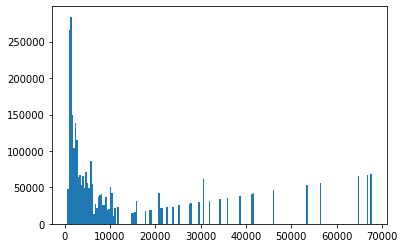

In [19]:
plt.hist(data['PUMA_TOTAL_POP'], bins = 200)